# Model Creation

After cleaning and getting a preliminary idea of the data, we're going to fit several models and evaluate them using the Mean Absolute Error (MAE). The models I'm going to try are:

* Linear Regression
* Ridge Regression
* Lasso Regression
* RandomForestRegressor

For the metrics, I'm also using the mean absolute error to tell a more concrete story of how well our model is performing. Instead of mean squared error, I used mean absolute error because we have several large outliers and I don't want our metric to be skewed by the large errors that'd be generated when we try to predict them using a model meant for typical revenue. It's also more interpretable, with the error returned simply being how many dollars, on average, we're off from the actual weekly revenue.

In [1]:
#Importing necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

## Reading in the original data

In [2]:
#Reading in the original test data
df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\train_all_features.csv', 
                 index_col=0)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,...,Week_of_year,Day,Median_Sales,Lagged_Value,Lag_Available,Diff_from_Med,IsThanksgiving,IsChristmas,IsPreChristmas,IsDept72
106604,1,1,46039.49,True,38.51,2.548,211.242170,8.106,151315,1,...,6,12,19239.405,19239.405,False,0.000,False,False,False,False
106610,1,1,19403.54,False,46.63,2.561,211.319643,8.106,151315,1,...,8,26,19239.405,19239.405,False,0.000,False,False,False,False
106598,1,1,21827.90,False,46.50,2.625,211.350143,8.106,151315,1,...,9,5,19239.405,19403.540,True,164.135,False,False,False,False
106620,1,1,21043.39,False,57.79,2.667,211.380643,8.106,151315,1,...,10,12,19239.405,21827.900,True,2588.495,False,False,False,False
106607,1,1,57258.43,False,62.27,2.719,210.820450,7.808,151315,1,...,13,2,19239.405,19239.405,False,0.000,False,False,False,False


## Feature Selection

First, I'm going to see whether the logged revenue or the original revenue generates less error for each model. After finding that, I would then do feature selection to find the most important features for that particular model.

### Determining whether to use logged or unlogged values

In [4]:
#Creating Features and Target
X = df.drop(['Weekly_Sales','log_revenue'], axis=1).values
y_log = df['log_revenue'].values
y_not = df['Weekly_Sales'].values

#Creating training and testing dataset.
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=0)
X_train_not, X_test_not, y_train_not, y_test_not = train_test_split(X, y_not, test_size=0.3, random_state=0)

As we're going to be doing this a lot, I wrote a function to split the data into training and testing set, fit the model (without any hyperparameter tuning), and evaluate the model.

In [9]:
#Function for creating training and testing dataset
def mean_abs_error(y,model):
    if (y == y_log).all():
        model.fit(X_train_log, y_train_log)
        y_pred = model.predict(X_test_log)
        y_pred = np.exp(y_pred) - 4989.94
        y_true = np.exp(y_test_log)
    else:
        model.fit(X_train_not, y_train_not)
        y_pred = model.predict(X_test_not)
        y_true = y_test_not
    return mean_absolute_error(y_true, y_pred)

#### Linear Regression

In [10]:
#Linear
linear = LinearRegression()

print("The mean absolute error calculated using the logged values is " + str(round(mean_abs_error(y_log,linear),2)))
print("The mean absolute error calculated using the original values is " + str(round(mean_abs_error(y_not,linear),2)))

The mean absolute error calculated using the logged values is 21251.63
The mean absolute error calculated using the original values is 2248.57


It's clear that the original values perform better. Next, we're going to test RandomForestRegressor. I didn't test Lasso and Ridge regression because they're very similar to Linear Regression, and the dataset that performs better for Linear Regression is likely to replicate its success for Lasso and Ridge Regression.

#### RandomForestRegressor

In [11]:
#RandomForestRegressor
rf = RandomForestRegressor()

print("The mean absolute error calculated using the logged values is " + str(round(mean_abs_error(y_log,rf),2)))
print("The mean absolute error calculated using the original values is " + str(round(mean_abs_error(y_not,rf),2)))

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The mean absolute error calculated using the logged values is 5470.69
The mean absolute error calculated using the original values is 1904.02


In both cases, it appears that we should predict using the original values as they generate the smaller MAE.

### RFE feature selector for Linear Regression model

Next, we're going to try to eliminate some of the extraneous features for Linear Regression and its relatives (Lasso and Ridge Regression). I didn't do this for RandomForestRegressor because it has a built-in feature that measures feature importance.

First, we find the optimal number of features for our linear regression model, which we defined above (linear) when comparing prelimary results between logged and unlogged values.

In [13]:
#Total number of features
n_features = len(df.drop(['Weekly_Sales','log_revenue'], axis=1).columns)
options = np.arange(1,n_features)
low_score = 4000 #A number we're certainly going to be lower than
nof = 0

#Fitting model
for n in tqdm(range(len(options))):
    
    #Creating model
    rfe = RFE(linear, options[n])
    X_train_rfe = rfe.fit_transform(X_train_not,y_train_not)
    X_test_rfe = rfe.transform(X_test_not)
    
    #Fitting model
    linear.fit(X_train_rfe,y_train_not)
    y_pred = linear.predict(X_test_rfe)
    score = mean_absolute_error(y_test_not, y_pred)
    if(score<low_score):
        low_score = score
        nof = options[n]
    
print(nof, round(low_score,2))

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:56<00:00,  1.78s/it]


20 2245.4


It appears that a linear regression model with 20 features performs the best, with a mean absolute error or 2245.40 dollars. That is 3 dollars less than our preliminary model without any feature selection, so it is an improvement. Now let's find out what those features are.

In [14]:
#Initializing RFE model and transforming the data with it.
rfe_linear = RFE(linear, nof)
X_rfe = rfe_linear.fit_transform(X_train_not,y_train_not)

#Fitting the data to model
linear.fit(X_rfe,y_train_not)

#Visualizing which ones are most important
cols = list(df.drop(['Weekly_Sales','log_revenue'],axis=1).columns)

temp = pd.Series(rfe_linear.support_,index = cols)
temp

Store              True
Dept               True
IsHoliday          True
Temperature        True
Fuel_Price         True
CPI               False
Unemployment       True
Size              False
Type_A             True
Type_B             True
Type_C             True
Total_MarkDown    False
Year               True
Month              True
Week_of_year       True
Day                True
Median_Sales       True
Lagged_Value       True
Lag_Available      True
Diff_from_Med     False
IsThanksgiving     True
IsChristmas        True
IsPreChristmas     True
IsDept72           True
dtype: bool

As it apears, the CPI, difference of the previous week from the median, total markdown, and size are not important for predicting the revenue generated.

In [15]:
selected_features_rfe_linear = list(temp[temp==True].index)

#Creating and saving the resulting dataframe
df_linear = df[selected_features_rfe_linear]
df_linear_revenue = df_linear.join(df['Weekly_Sales'], how='outer')
df_linear_revenue.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\original_train_linear.csv')
df_linear_revenue.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,Unemployment,Type_A,Type_B,Type_C,Year,...,Week_of_year,Day,Median_Sales,Lagged_Value,Lag_Available,IsThanksgiving,IsChristmas,IsPreChristmas,IsDept72,Weekly_Sales
106604,1,1,True,38.51,2.548,8.106,1,0,0,2010,...,6,12,19239.405,19239.405,False,False,False,False,False,46039.49
106610,1,1,False,46.63,2.561,8.106,1,0,0,2010,...,8,26,19239.405,19239.405,False,False,False,False,False,19403.54
106598,1,1,False,46.50,2.625,8.106,1,0,0,2010,...,9,5,19239.405,19403.540,True,False,False,False,False,21827.90
106620,1,1,False,57.79,2.667,8.106,1,0,0,2010,...,10,12,19239.405,21827.900,True,False,False,False,False,21043.39
106607,1,1,False,62.27,2.719,7.808,1,0,0,2010,...,13,2,19239.405,19239.405,False,False,False,False,False,57258.43


## Standardizing the data and finding PCA

For both the original dataset and the feature selected dataset, I'm going to standardize the features, do principal component analysis (PCA) on them, and compare the mean absolute error generated between the three datasets.

### Standardization

First, we're going to scale the **feature selected** data

In [16]:
#Standardizing the feature selected data
scaler = StandardScaler()

scaled_df_linear = scaler.fit_transform(df_linear)
scaled_df_linear = pd.DataFrame(scaled_df_linear)
scaled_df_linear = scaled_df_linear.join(df['Weekly_Sales'], how='outer')
scaled_df_linear.columns = df_linear_revenue.columns

#Saving the data
scaled_df_linear.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train_linear.csv')
scaled_df_linear.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,Unemployment,Type_A,Type_B,Type_C,Year,...,Week_of_year,Day,Median_Sales,Lagged_Value,Lag_Available,IsThanksgiving,IsChristmas,IsPreChristmas,IsDept72,Weekly_Sales
0,-1.658029,-1.419057,3.640258,-1.171151,-1.771255,0.073834,0.976671,-0.795179,-0.334865,-1.213542,...,-1.402269,-0.419545,0.190542,0.158578,-1.381278,-0.118986,-0.119551,-0.120143,-0.120552,87235.57
1,-1.658029,-1.419057,-0.274706,-0.730958,-1.742908,0.073834,0.976671,-0.795179,-0.334865,-1.213542,...,-1.260862,1.180835,0.190542,0.158578,-1.381278,-0.118986,-0.119551,-0.120143,-0.120552,80254.53
2,-1.658029,-1.419057,-0.274706,-0.738006,-1.603354,0.073834,0.976671,-0.795179,-0.334865,-1.213542,...,-1.190159,-1.219735,0.190542,0.165984,0.723967,-0.118986,-0.119551,-0.120143,-0.120552,77715.58
3,-1.658029,-1.419057,-0.274706,-0.125964,-1.511771,0.073834,0.976671,-0.795179,-0.334865,-1.213542,...,-1.119456,-0.419545,0.190542,0.275378,0.723967,-0.118986,-0.119551,-0.120143,-0.120552,83599.56
4,-1.658029,-1.419057,-0.274706,0.116900,-1.398383,-0.085692,0.976671,-0.795179,-0.334865,-1.213542,...,-0.907346,-1.562674,0.190542,0.158578,-1.381278,-0.118986,-0.119551,-0.120143,-0.120552,77876.10


First, we're going to scale the **not feature selected** data

In [17]:
#Standardizing the non-feature selected data
scaler = StandardScaler()

scaled_df = scaler.fit_transform(df.drop(['Weekly_Sales','log_revenue'],axis=1))
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df.drop(['Weekly_Sales','log_revenue'],axis=1).columns
scaled_df = scaled_df.join(df['Weekly_Sales'], how='outer')

#Saving the data
scaled_df.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train.csv')
scaled_df.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_B,...,Day,Median_Sales,Lagged_Value,Lag_Available,Diff_from_Med,IsThanksgiving,IsChristmas,IsPreChristmas,IsDept72,Weekly_Sales
0,-1.658029,-1.419057,3.640258,-1.171151,-1.771255,1.022305,0.073834,0.239093,0.976671,-0.795179,...,-0.419545,0.190542,0.158578,-1.381278,-0.092290,-0.118986,-0.119551,-0.120143,-0.120552,87235.57
1,-1.658029,-1.419057,-0.274706,-0.730958,-1.742908,1.024284,0.073834,0.239093,0.976671,-0.795179,...,1.180835,0.190542,0.158578,-1.381278,-0.092290,-0.118986,-0.119551,-0.120143,-0.120552,80254.53
2,-1.658029,-1.419057,-0.274706,-0.738006,-1.603354,1.025062,0.073834,0.239093,0.976671,-0.795179,...,-1.219735,0.190542,0.165984,0.723967,-0.063237,-0.118986,-0.119551,-0.120143,-0.120552,77715.58
3,-1.658029,-1.419057,-0.274706,-0.125964,-1.511771,1.025841,0.073834,0.239093,0.976671,-0.795179,...,-0.419545,0.190542,0.275378,0.723967,0.365888,-0.118986,-0.119551,-0.120143,-0.120552,83599.56
4,-1.658029,-1.419057,-0.274706,0.116900,-1.398383,1.011536,-0.085692,0.239093,0.976671,-0.795179,...,-1.562674,0.190542,0.158578,-1.381278,-0.092290,-0.118986,-0.119551,-0.120143,-0.120552,77876.10


## Model creation:

First, let's read in our data which we processed above.

### Feature Selected (Linear, Ridge, and Lasso Regression)

In [14]:
scaled_df_fs = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train_linear.csv',index_col=0)
original_df_fs = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\original_train_linear.csv',index_col=0)

### Not Feature Selected (RandomForestRegressor)

In [2]:
scaled_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train.csv',index_col=0)
original_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\train_all_features.csv',index_col=0)

In [3]:
original_df = original_df.drop('log_revenue',axis=1)

### Train test split

It's troublesome to create training and testing datasets for all 4 datasets, so I wrote a function that returns a tuple of training and test datasets.

In [4]:
def create_train_test(data):
    data = data.sort_values(['Year','Week_of_year'])
    train = data.iloc[:-56490,:]
    test = data.iloc[-56490:,:]
    return train, test

In [15]:
scaled_fs_train, scaled_fs_test = create_train_test(scaled_df_fs)
original_fs_train, original_fs_test = create_train_test(original_df_fs)
scaled_train, scaled_test = create_train_test(scaled_df)
original_train, original_test = create_train_test(original_df)

### A hyperparameter optimizer.

RandomForest, as well as Lasso and Ridge Regression, have hyperparameters that need to be optimized for best performance. I wrote a function to expedite this process. All I need to input is the model, the hyperparameters tested in dictionary format, and the data to fit the model to.

In [7]:
#Writing a function to find best hyperparams
def optimize_params(model, params, train):
    """
    Select the best parameters out of a dict for a model given training data
    """
    #Train_test_split
    X = train.drop(['Weekly_Sales'], axis=1).values
    y = train['Weekly_Sales'].values
    
    #Search for best combination of hyperparameters from the dictionary
    reg = model()
    reg_cv = GridSearchCV(reg, param_grid=params, scoring='neg_mean_absolute_error',cv=5)
    reg_cv.fit(X, y)
    print(reg_cv.best_params_)

### Cross-validate

This will give us cross-validated results on the data.

In [8]:
def cross_validate(train,model):
    X = train.drop(['Weekly_Sales'], axis=1).values
    y = train['Weekly_Sales'].values
    results = []
    tscv = TimeSeriesSplit(n_splits=4)
    for train_index, validate_index in tscv.split(X):
        X_train, X_validate = X[train_index], X[validate_index]
        y_train, y_validate = y[train_index], y[validate_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_validate)
        results.append(mean_absolute_error(y_validate,y_pred))
    return results

## Linear Regression

The process goes as follows: each dataset is put through the create_test_split function created above, cross-validated after fitting, and the results are saved and plotted in a bar graph. If there's anything interesting, they'll be noted later.

In [46]:
#Create LinearRegression Model
linear = LinearRegression()

#Fit and cross-validate
scaled_results = cross_validate(scaled_fs_train,linear)
original_results = cross_validate(original_fs_train,linear)

Then, after getting the scores, we find the mean and standard deviation. Since the scoring is negative mean absolute error, I will multiply the means by -1 to get the MAE and plot them with their standard deviations in a bar plot.

In [47]:
means = [np.mean(scaled_results)*-1, np.mean(original_results)*-1]
stds = [np.std(scaled_results), np.std(original_results)]

#### Graphing

[-16030153634809.344, -2641.0220804752853]
[25730339599767.39, 595.4411916995354]


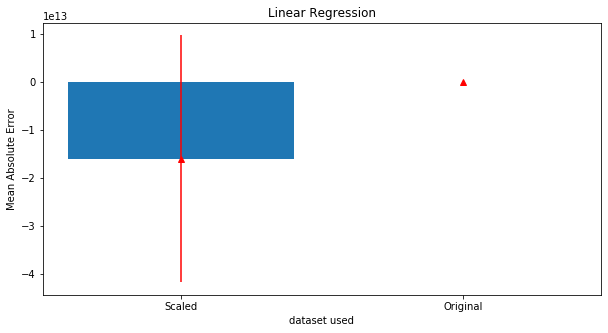

In [49]:
plt.figure(figsize=(10,5))

#Data
plt.bar(range(2),means)
plt.errorbar(range(2), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(2),['Scaled','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Linear Regression")

print(means)
print(stds)

It appears that the original dataset performs the best (has the lowest MAE) for Linear Regression. 

### Ridge Regression

For Ridge and Lasso Regression, we need to first search for the best value of alpha. 

In [11]:
model = Ridge
params_to_test = {'alpha':np.arange(0.0001, 0.001, 0.0001)}

optimize_params(model, params_to_test, scaled_fs_train)
optimize_params(model, params_to_test, original_fs_train)

{'alpha': 0.0009000000000000001}
{'alpha': 0.0009000000000000001}


Using the alphas found above, we create our models. After creating the models, we find the mean negative absolute error, multiple it by -1, and graph it in a bar plot with the standard deviation just like we've done before.

#### Scaled

In [60]:
#Create Ridge Regression Model
ridge = Ridge(alpha=0.0009)

#Fit and cross-validate
scaled_results = cross_validate(scaled_fs_train,ridge)

#### Original Dataset

In [61]:
#Create Ridge Regression Model
ridge = Ridge(alpha=0.0009)

#Fit and cross-validate
original_results = cross_validate(original_fs_train,ridge)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.20727e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.08893e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.16323e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.38062e-18): result may not be accurate.
  overwrite_a=True).T


In [64]:
means = [np.mean(scaled_results), np.mean(original_results)]
stds = [np.std(scaled_results), np.std(original_results)]

#### Graphing

[14979.073240770183, 2641.021164915798]
[542.5954715817803, 595.4412742692111]


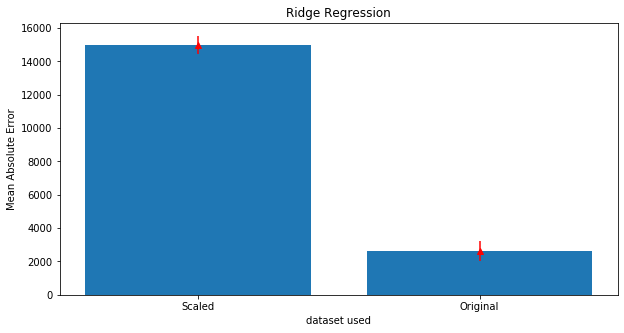

In [65]:
plt.figure(figsize=(10,5))

#Data
plt.bar(range(2),means)
plt.errorbar(range(2), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(2),['Scaled','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Ridge Regression")

print(means)
print(stds)

### Lasso

Similar to Ridge Regression, I first optimized the alpha value before fitting the models and getting the MAE.

In [12]:
model = Lasso
params_to_test = {'alpha':np.arange(0.00001, 0.0001, 0.00001)}

optimize_params(model, params_to_test, scaled_fs_train)
optimize_params(model, params_to_test, original_fs_train)

{'alpha': 9e-05}
{'alpha': 9e-05}


#### Scaled

In [16]:
#Create Model
lasso = Lasso(alpha=0.00009)

#Fit and cross-validate
scaled_results = cross_validate(scaled_fs_train,lasso)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11303884538317.4, tolerance: 2267658827.652851
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22149400231778.566, tolerance: 4438731348.000519
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33459212443040.406, tolerance: 6700939594.205903
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

#### Original Dataset

In [17]:
#Create Model
lasso = Lasso(alpha=0.00009)

#Fit and cross-validate
original_results = cross_validate(original_fs_train,lasso)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391484112402.4717, tolerance: 2156971751.712764
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1831039451651.419, tolerance: 4538919009.380867
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2776595026542.0786, tolerance: 6828328948.610277
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

In [18]:
means = [np.mean(scaled_results), np.mean(original_results)]
stds = [np.std(scaled_results), np.std(original_results)]

#### Graphing

[15045.887587558565, 2631.3951661824544]
[495.0612487436551, 597.9046126330941]


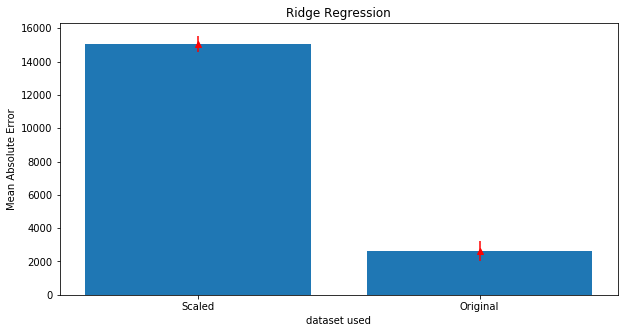

In [19]:
plt.figure(figsize=(10,5))

#Data
plt.bar(range(2),means)
plt.errorbar(range(2), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(2),['Scaled','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Ridge Regression")

print(means)
print(stds)

### RandomForestRegressor

I tested for the optimal number of trees ("n_estimators") because that is the most important hyperparameter to tune. 

In [20]:
model = RandomForestRegressor
params_to_test = {'n_estimators':[100,125,150,175],
                 'max_depth':[10,20,50,None],
                 'max_features':['log2','sqrt','auto',None]}

optimize_params(model, params_to_test, scaled_train)
optimize_params(model, params_to_test, original_train)

{'max_depth': 50, 'max_features': None, 'n_estimators': 175}
{'max_depth': 50, 'max_features': 'log2', 'n_estimators': 150}


#### Scaled

In [21]:
#Create RandomForest Model
rf = RandomForestRegressor(n_estimators=175)

#Fit and cross-validate
scaled_results = cross_validate(scaled_train,rf)

#### Original Dataset

In [22]:
#Create Model
rf = RandomForestRegressor(n_estimators=150)

#Fit and cross-validate
original_results = cross_validate(original_train,rf)

In [23]:
means = [np.mean(scaled_results), np.mean(original_results)]
stds = [np.std(scaled_results), np.std(original_results)]

[11766.209237179779, 2573.7507288653596]
[1987.8664479350477, 648.341499872729]


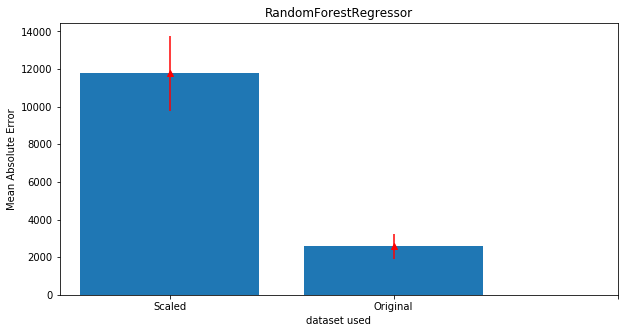

In [24]:
plt.figure(figsize=(10,5))
plt.bar(range(2),means)
plt.errorbar(range(2), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("RandomForestRegressor")

print(means)
print(stds)

Now, let's look at the feature importance of the last RandomForestRegressor model.

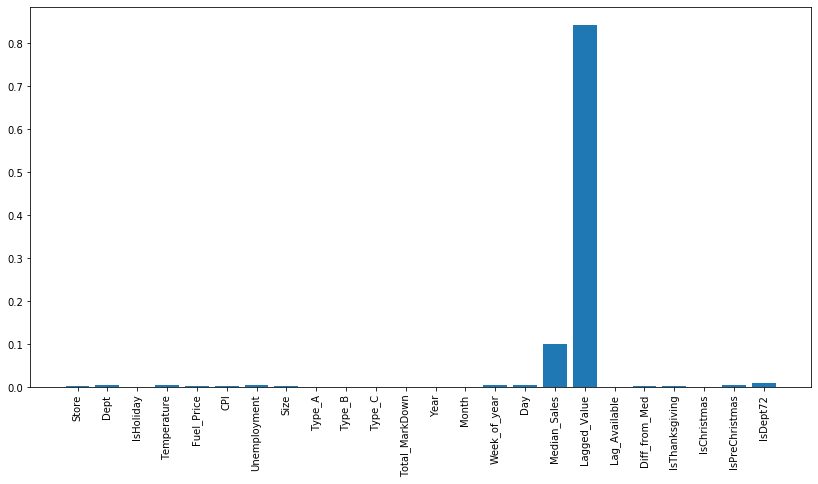

In [87]:
plt.figure(figsize=(14,7))
plt.bar(range(len(rf.feature_importances_)),rf.feature_importances_)
plt.xticks(range(len(rf.feature_importances_)),original_df.drop('Weekly_Sales',axis=1).columns,rotation=90)
plt.show()

#### XGBoost

In [26]:
from xgboost import XGBRegressor

In [25]:
model = XGBRegressor
params_to_test = {'eta':[0.05,0.1,0.15,0.2,0.3,0.4],
                  'min_child_weight':[0.5,1,1.5],
                 'max_depth':[4,6,8,10],
                 'eval_metrix':['mae']}

optimize_params(model, params_to_test, scaled_train)
optimize_params(model, params_to_test, original_train)

{'eta': 0.05, 'eval_metrix': 'mae', 'max_depth': 10, 'min_child_weight': 1.5}
{'eta': 0.05, 'eval_metrix': 'mae', 'max_depth': 10, 'min_child_weight': 0.5}


#### Scaled

In [27]:
#Create Model
xgb = XGBRegressor(eta=0.05, eval_metrix='mae', max_depth=10, min_child_weight=1.5)

#Fit and cross-validate
scaled_results = cross_validate(scaled_train,xgb)

[17:23:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:23:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:24:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:25:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Original Dataset

In [28]:
#Create Model
xgb = XGBRegressor(eta=0.05, eval_metrix='mae', max_depth=10, min_child_weight=0.5)

#Fit and cross-validate
original_results = cross_validate(original_train,xgb)

[19:28:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:29:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
means = [np.mean(scaled_results), np.mean(original_results)]
stds = [np.std(scaled_results),np.std(original_results)]

[13107.881660335448, 2224.515777674403]
[1322.1414115654436, 512.5058163008931]


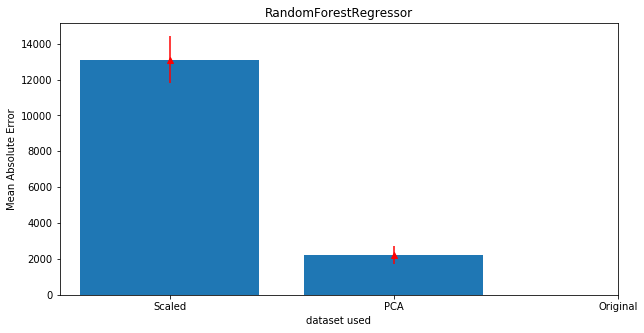

In [30]:
plt.figure(figsize=(10,5))
plt.bar(range(2),means)
plt.errorbar(range(2), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("RandomForestRegressor")

print(means)
print(stds)

### SVR

In [31]:
from sklearn.svm import SVR

In [32]:
model = SVR
params_to_test = {'C':np.arange(0.1, 0.4, 0.1),'kernel':['linear', 'rbf']}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, original_df)

{'C': 0.1, 'kernel': 'rbf'}
{'C': 0.2, 'kernel': 'rbf'}


#### Scaled

In [33]:
#Create Model
svr = SVR(C=0.1, kernel='rbf')

#Fit and cross-validate
scaled_results = cross_validate(scaled_train,svr)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

#### Original Dataset

In [34]:
#Create Model
svr = SVR(C=0.2, kernel='rbf')

#Fit and cross-validate
original_results = cross_validate(original_train,svr)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

In [35]:
means = [np.mean(scaled_results), np.mean(original_results)]
stds = [np.std(scaled_results),np.std(original_results)]

[13345.275260168855, 13431.923854106131]
[253.73299676109, 347.77476031605823]


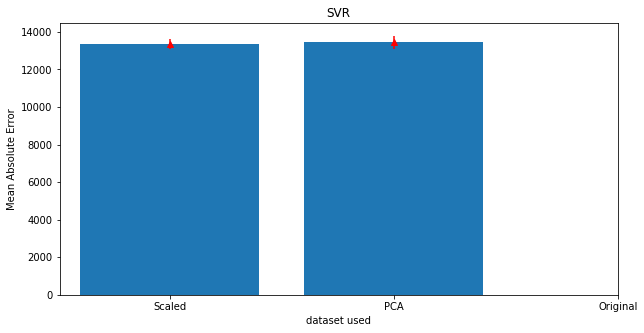

In [36]:
plt.figure(figsize=(10,5))
plt.bar(range(2),means)
plt.errorbar(range(2), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("SVR")

print(means)
print(stds)

As can be seen, XGBoost using the original dataset gave the lowest MAE (2224 dollars). I will save this model, run it on the testing set to see how well it does.

In [37]:
import pickle
X_train = original_train.drop('Weekly_Sales',axis=1)
y_train = original_train['Weekly_Sales']

model = XGBRegressor(eta=0.05, eval_metrix='mae', max_depth=10, min_child_weight=0.5)
reg = model.fit(X_train, y_train)
pickle.dump(reg, open('Final_regressor.model','wb'))

C:\Users\songs\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\songs\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:17:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [39]:
model = pickle.load(open('Final_regressor.model','rb'))

[12:23:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
X_test = original_test.drop('Weekly_Sales',axis=1)
y_test = original_test['Weekly_Sales']
y_pred = model.predict(X_test)
mean_absolute_error(y_test,y_pred)

1566.005085003585

So The final result is 1566.